# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Задание 8

**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`.
* Дедлайн **4 мая в 23:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb` и все фотографии, если пишете теоретическую часть от руки.
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.

-----

*Замечания.* Теоретические решения можно оформить
* в $\LaTeX$-формате в ноутбуке;
* написать от руки и прикрепить к ноутбуку;
* написать от руки и выслать боту.  

Во втором случае также **важно** "вшить" фото в ноутбук. Сделать это можно с помощью Edit -> Insert Image в Jupyter или с помощью кнопки "Вставить изображение" в Colab. Следите за размером итогового файла.

Фотографии принимаются только в хорошем качестве, **следите за освещением и почерком**. На фотографиях также указывайте номера задач.

-----

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.sandbox.stats.multicomp import multipletests
from math import floor

%matplotlib inline

## Задача 1: Белые мыши наносят ответный удар (продолжение)

Скачаем [данные](https://www.kaggle.com/ruslankl/mice-protein-expression) об экспрессии генов различных белков в головном мозге белых мышей.

В этом датасете представлены уровни экспрессии 77 белков, измеренные в коре головного мозга 8 классов мышей, некоторые из которых страдают синдромом Дауна, а некоторые были подвержены контекстному обусловливанию страха, задачи, используемой для оценки ассоциативного обучения.

Данные содержат информацию о 38 контрольных мышей и 34 трисомных мышей (синдром Дауна), то есть всего 72 мышки. Проведено 15 измерений каждого белка для каждой мышки, то есть каждой мыши соответствует несколько записей в таблице.

Загрузим данные и посмотрим на начало таблицы. Всего мы имеем 82 колонки, в большинстве их которых содержатся вещественные данные (уровни экспрессии 77 белков). Остальные колонки содержат категориальные данные (с небольшим числом значений).

**Предварительный анализ**

Эта часть цже оценена в прошлом дз, просто скопируйте графики.

In [2]:
data = pd.read_csv("./Data_Cortex_Nuclear.csv")
data.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


Чтобы вспомнить, что это за данные, для начала выведем простые описательные статистики по вещественным параметрам.

In [3]:
data.describe()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,...,1080.000000,867.000000,795.000000,1080.000000,1005.000000,1080.000000,900.000000,870.000000,810.000000,1080.000000
mean,0.425810,0.617102,0.319088,2.297269,3.843934,0.233168,0.181846,3.537109,0.212574,1.428682,...,0.226676,0.157914,0.134762,0.121521,0.131053,0.446073,0.169609,0.183135,0.205440,1.337784
std,0.249362,0.251640,0.049383,0.347293,0.933100,0.041634,0.027042,1.295169,0.032587,0.466904,...,0.028989,0.029537,0.027417,0.014276,0.023863,0.066432,0.059402,0.040406,0.055514,0.317126
min,0.145327,0.245359,0.115181,1.330831,1.737540,0.063236,0.064043,1.343998,0.112812,0.429032,...,0.155869,0.088305,0.080657,0.067254,0.085419,0.258626,0.079691,0.105537,0.101787,0.586479
25%,0.288121,0.473361,0.287444,2.057411,3.155678,0.205755,0.164595,2.479834,0.190823,1.203665,...,0.206395,0.136424,0.115554,0.110839,0.113506,0.398082,0.125848,0.155121,0.165143,1.081423
50%,0.366378,0.565782,0.316564,2.296546,3.760855,0.231177,0.182302,3.326520,0.210594,1.355846,...,0.224000,0.152313,0.129468,0.121626,0.126523,0.448459,0.158240,0.174935,0.193994,1.317441
75%,0.487711,0.698032,0.348197,2.528481,4.440011,0.257261,0.197418,4.481940,0.234595,1.561316,...,0.241655,0.174017,0.148235,0.131955,0.143652,0.490773,0.197876,0.204542,0.235215,1.585824
max,2.516367,2.602662,0.497160,3.757641,8.482553,0.539050,0.317066,7.464070,0.306247,6.113347,...,0.358289,0.282016,0.261506,0.158748,0.256529,0.759588,0.479763,0.360692,0.413903,2.129791


Количество записей каждого класса:

In [4]:
data['class'].value_counts()

c-CS-m    150
c-SC-m    150
c-CS-s    135
c-SC-s    135
t-CS-m    135
t-SC-m    135
t-SC-s    135
t-CS-s    105
Name: class, dtype: int64

Количество записей по генотипам:

In [5]:
data.Genotype.value_counts()

Control    570
Ts65Dn     510
Name: Genotype, dtype: int64

В начале исследования полезно посмотреть на данные визуально. Посмотрим на зависимость уровней экспрессии разных белков друг от друга. Визуализируйте данные в первых десяти колонках в двумерных проекциях, используя `sns.pairplot`. 

In [6]:
sns.set_style("darkgrid")

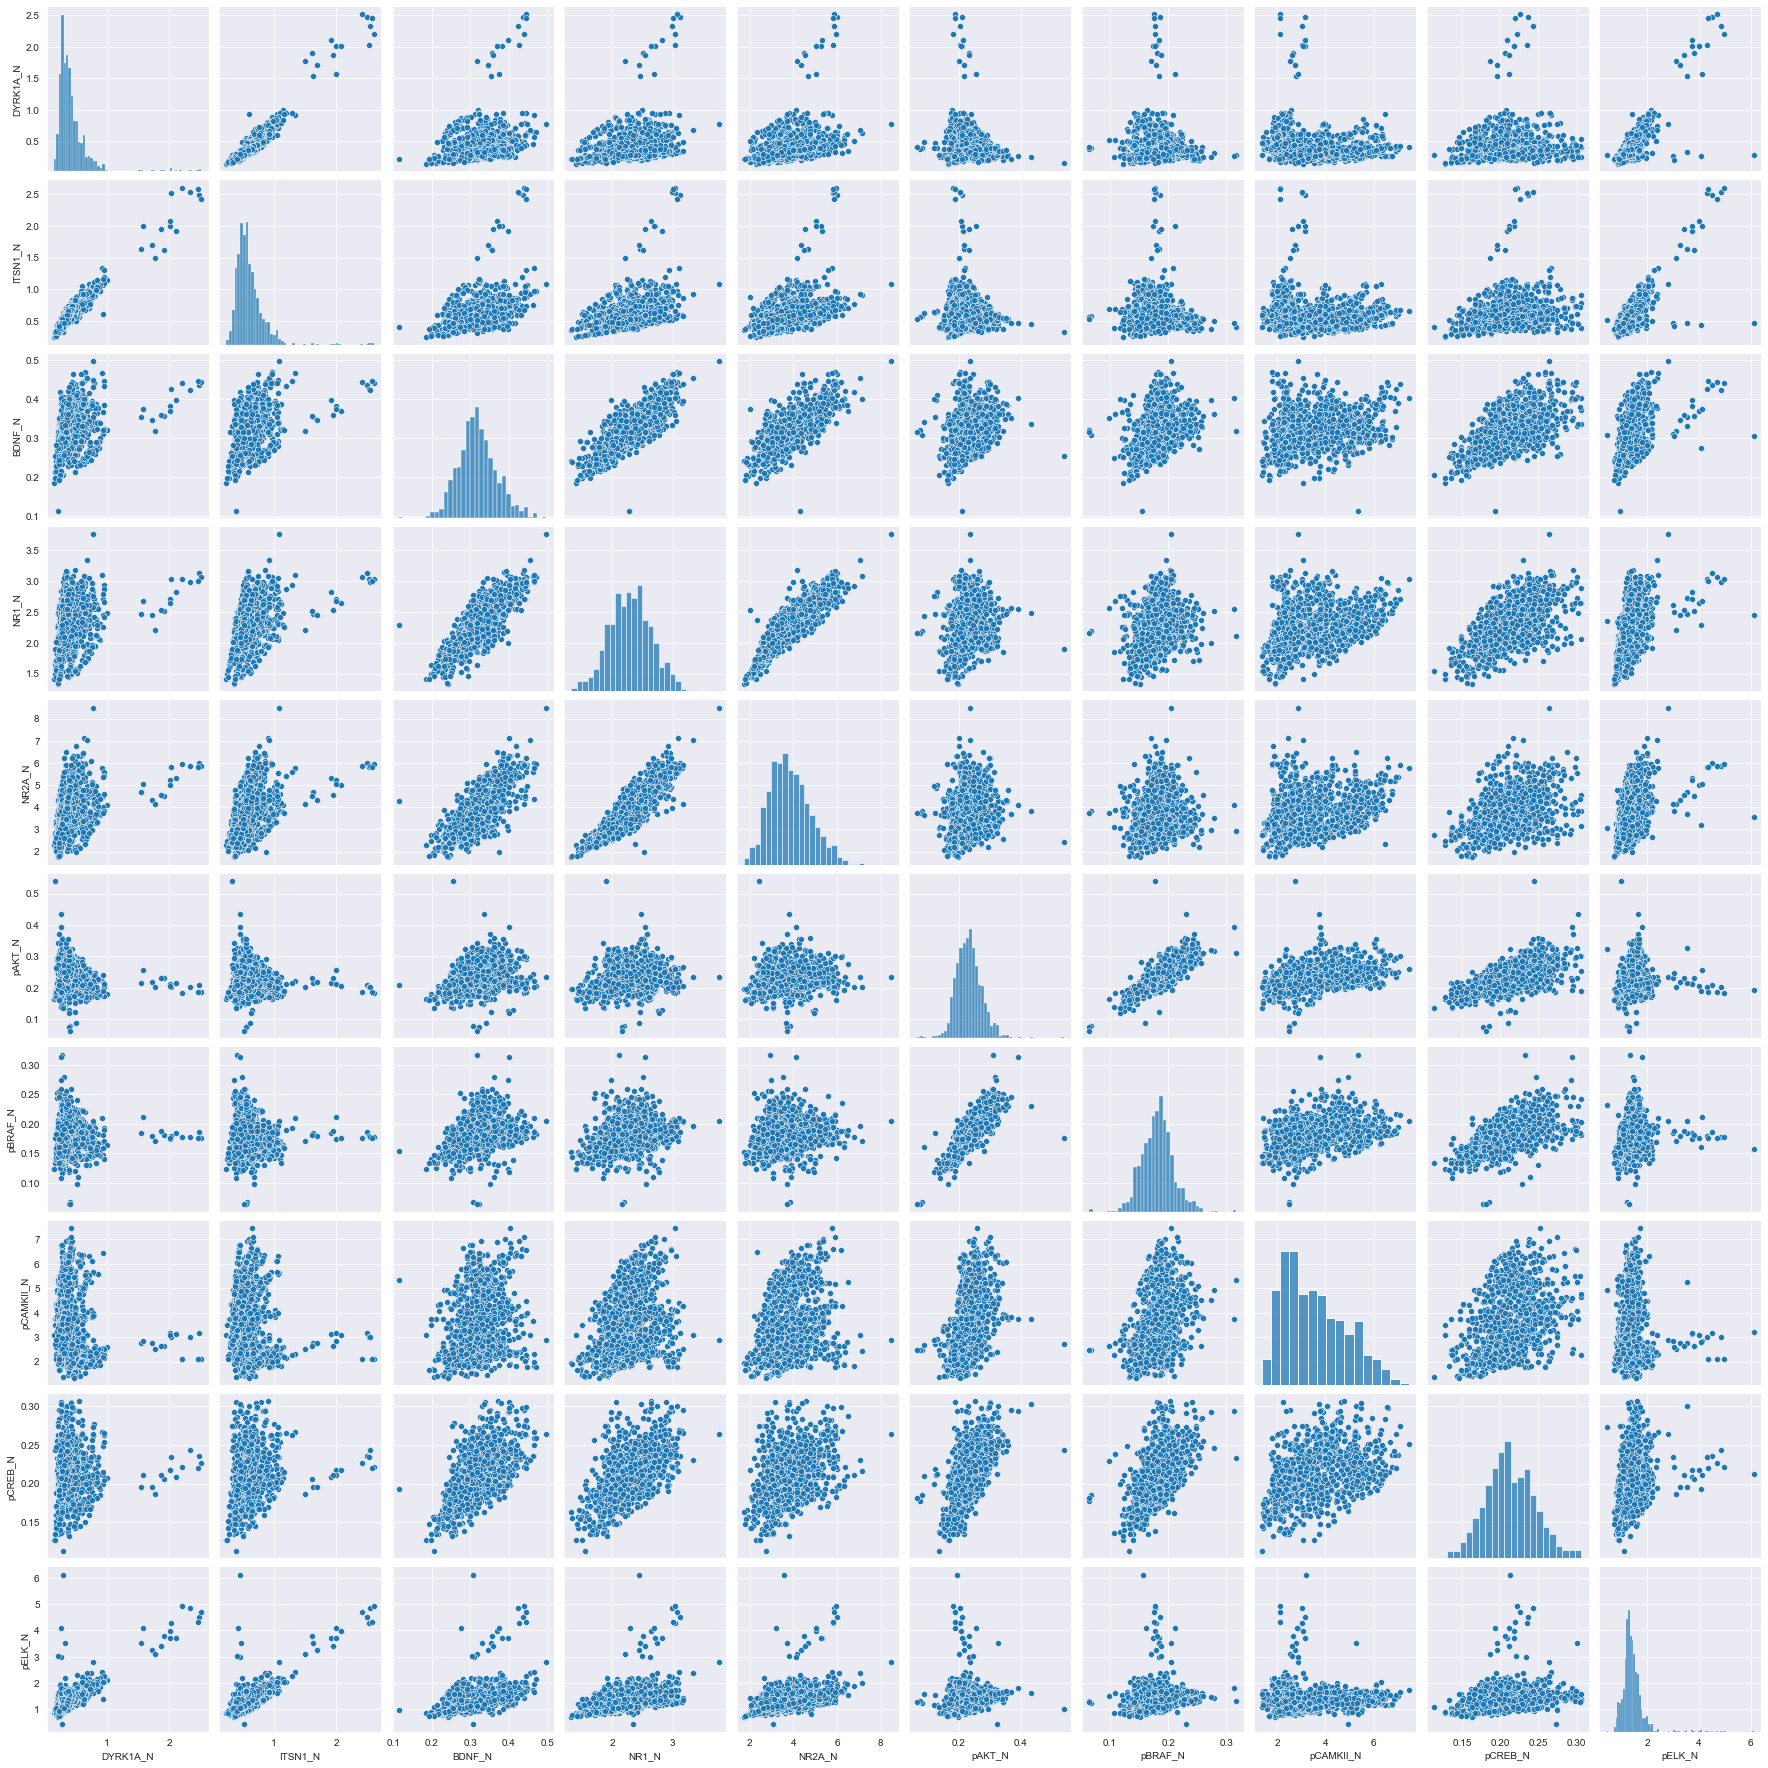

In [7]:
sns.pairplot(data.iloc[:, 1:11]);

При визуализации в двумерных проекциях можно также строить ядерные оценки плотности:

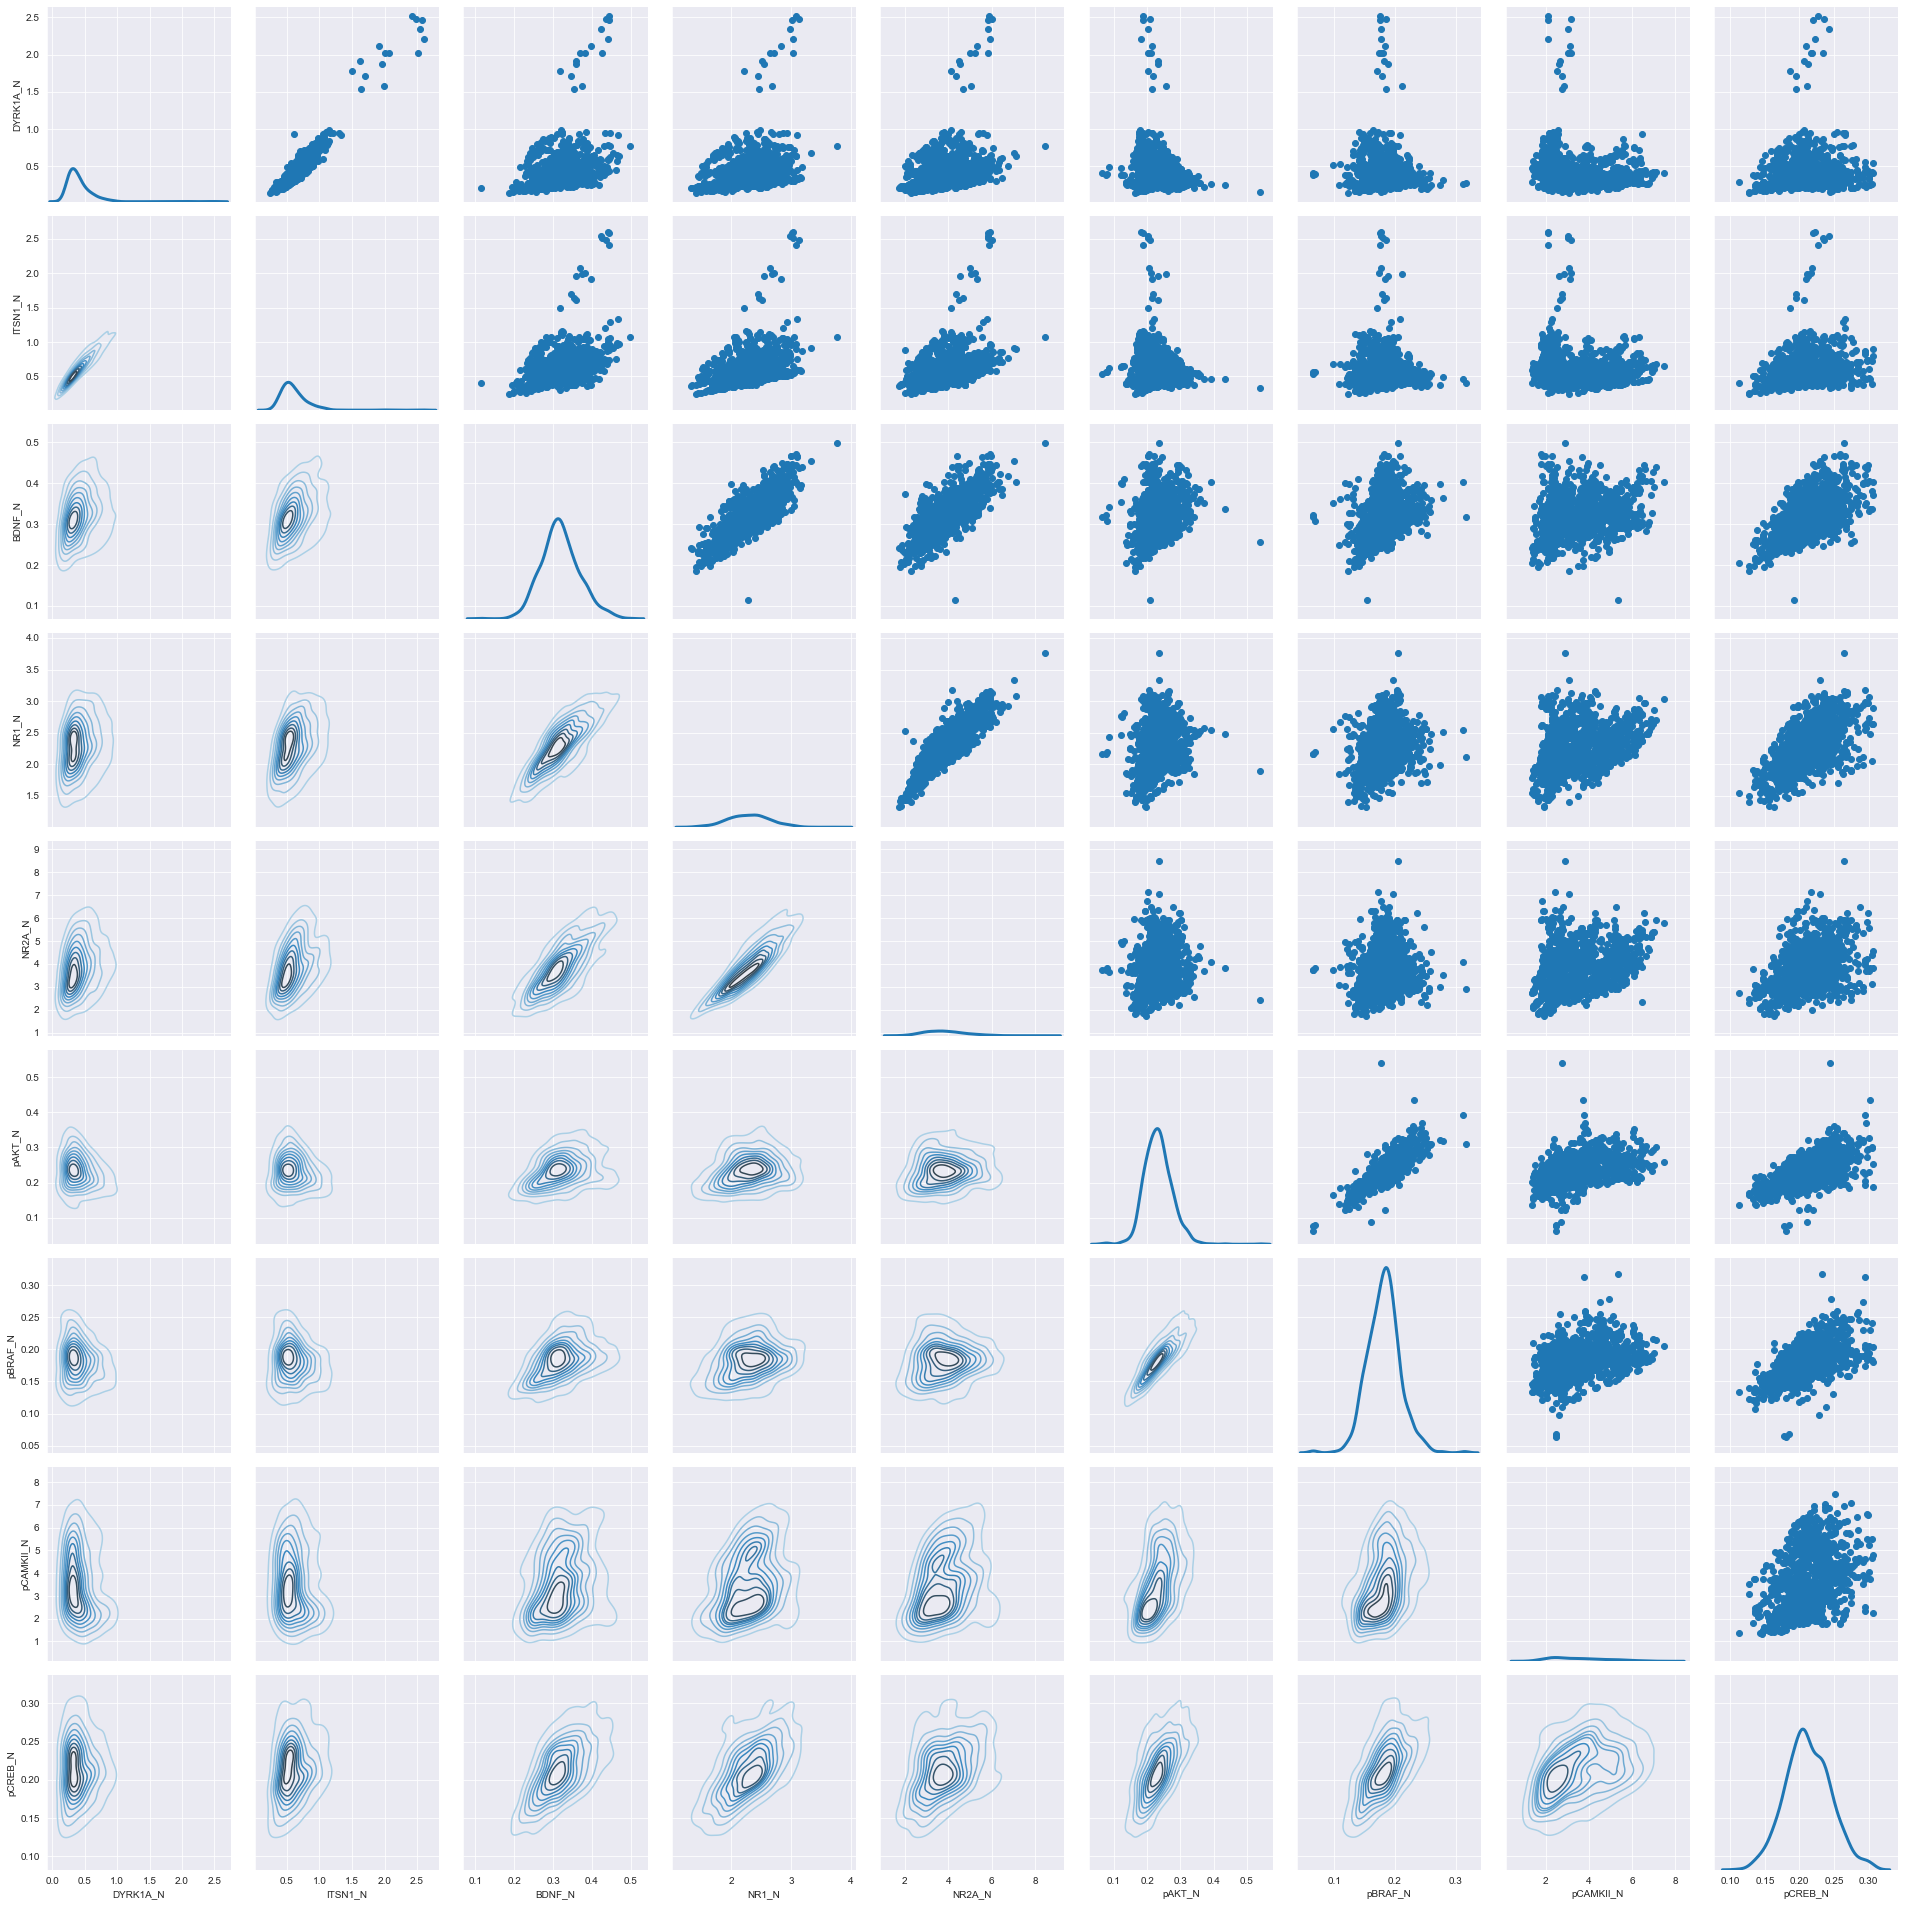

In [8]:
g = sns.PairGrid(data.iloc[:, 1:10].dropna(), height=3)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3);

Визуализируйте двумерные проекции данных и ядерные оценки плотности с использованием `sns.PairGrid` отдельно по генотипам для 10 признаков. Используйте `hue='Genotype'` при вызове `sns.PairGrid`. По параметру `hue`  происходит разделение датасета.

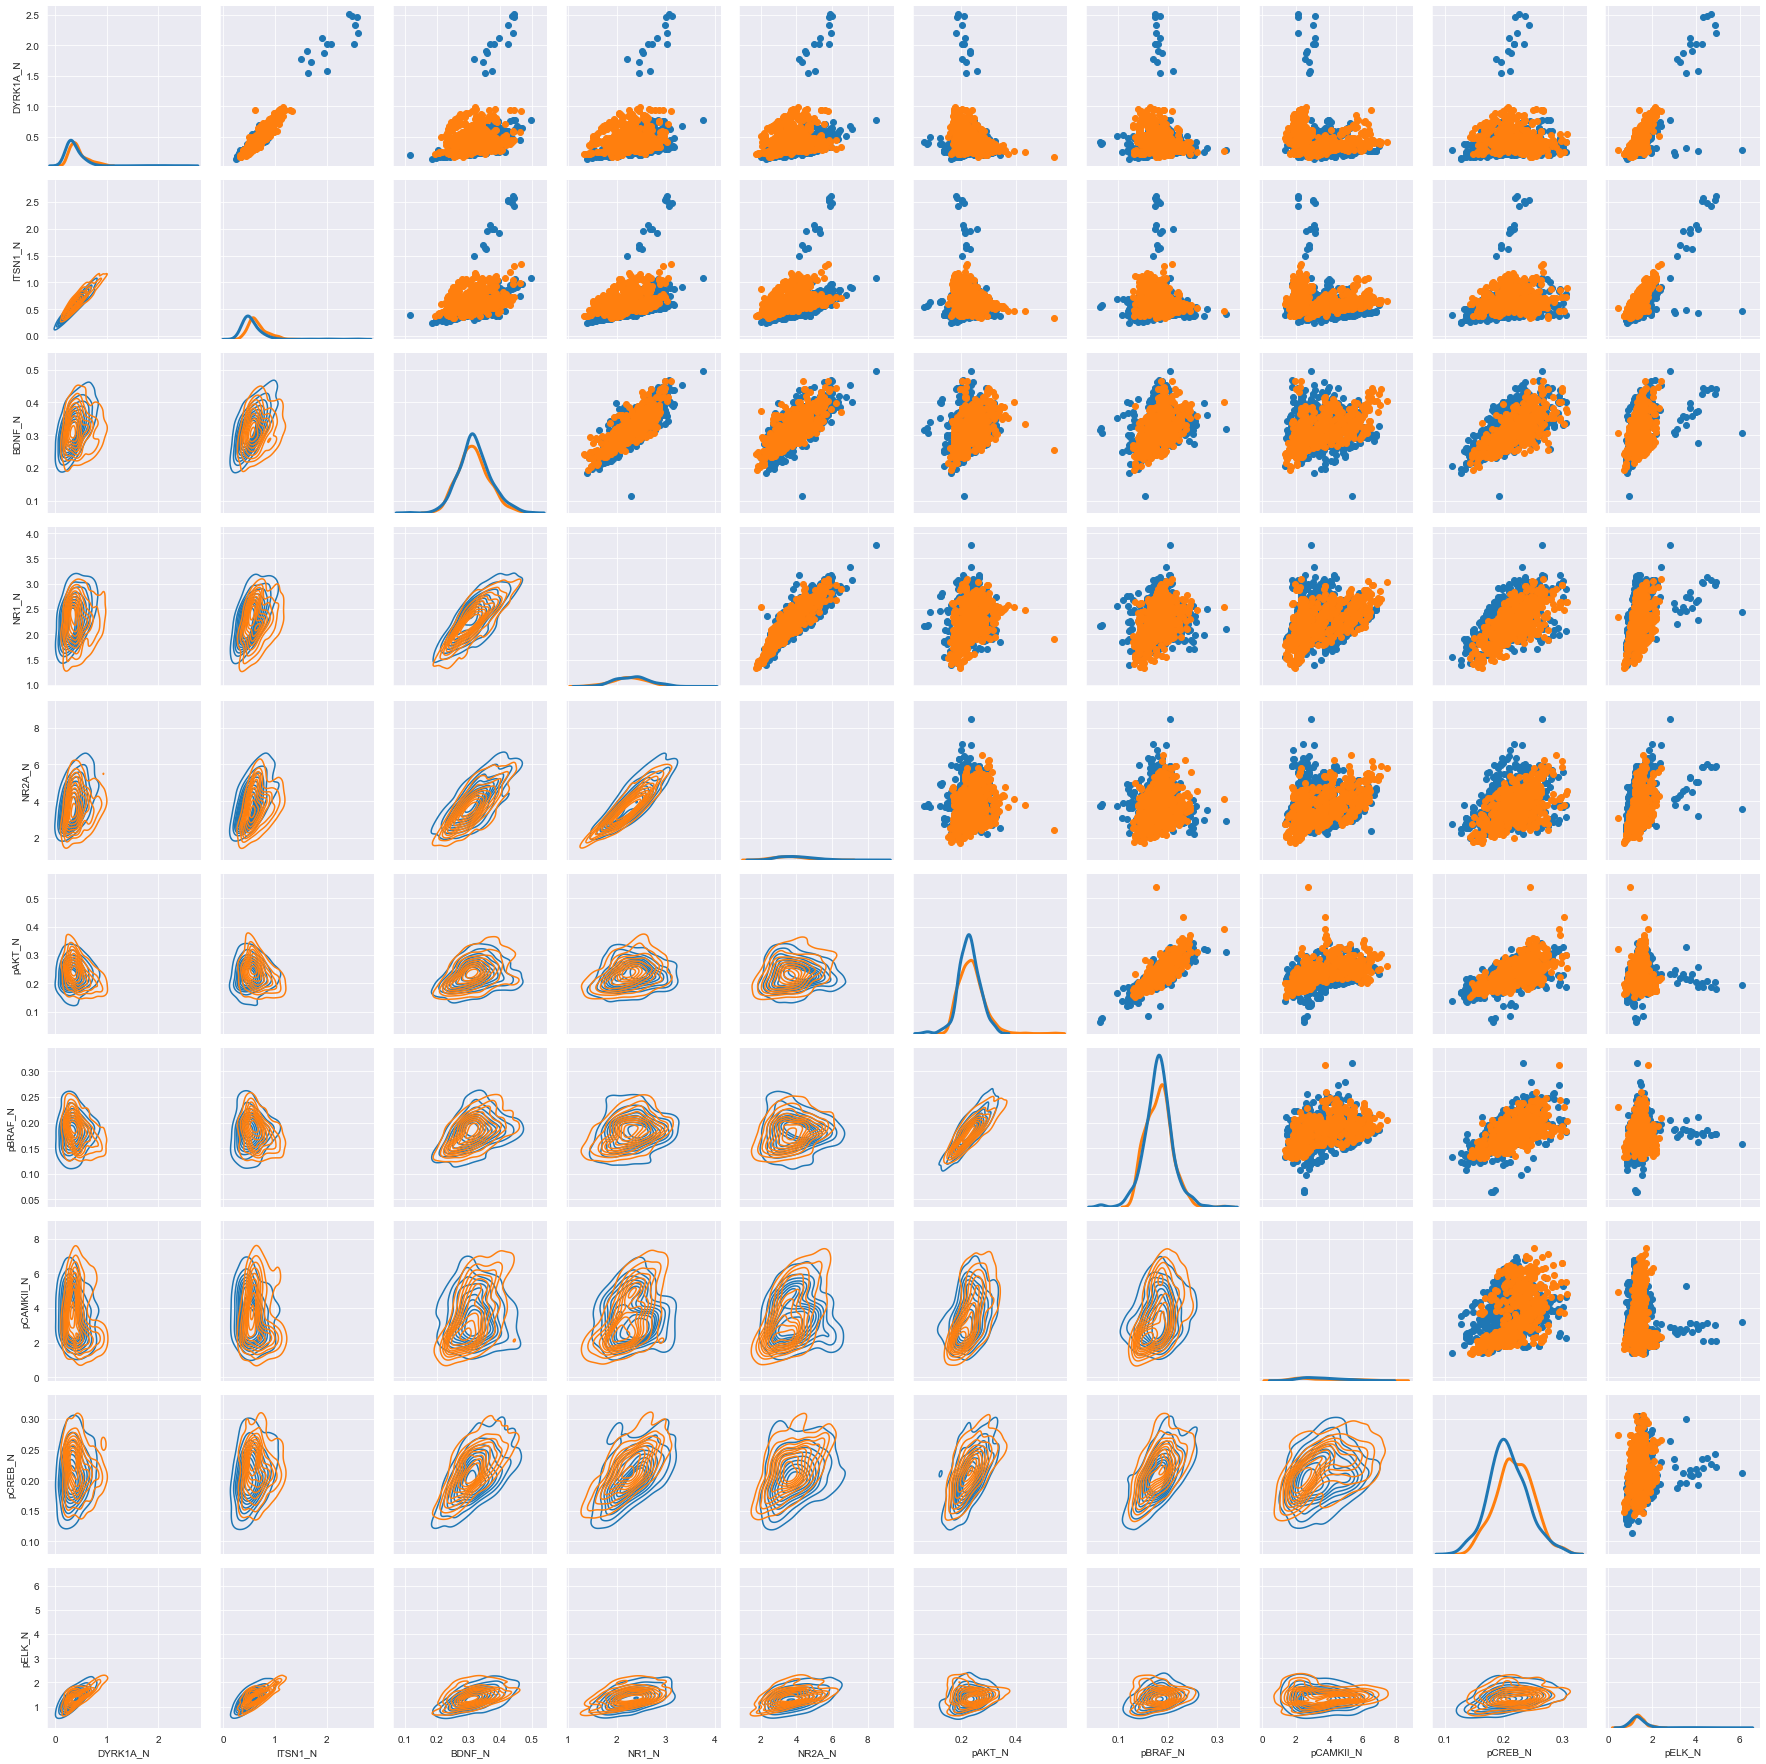

In [9]:
g = sns.PairGrid(data.iloc[:, 1:11].dropna().join(data.iloc[:, 78].dropna()), hue="Genotype")
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3);

#### 2. Дисперсионный анализ

##### 2.1. Зависимость распределения DYRK1A_N от генотипа

Проверьте гипотезу о равенстве распределений с использованием критерия Уилкоксона-Манна-Уитни с использованием различных альтернатив.  В реальных исследованиях нужно использовать конкретную альтернативу. 

Сделайте выводы. Также поясните, почему в данной задаче можно использовать этот критерий.

In [10]:
control_DYRK1A = data[data["Genotype"] == "Control"]["DYRK1A_N"].dropna()
down_DYRK1A = data[data["Genotype"] == "Ts65Dn"]["DYRK1A_N"].dropna()
print('two-sided:', sps.mannwhitneyu(control_DYRK1A, down_DYRK1A, alternative='two-sided'))
print('less:     ', sps.mannwhitneyu(control_DYRK1A, down_DYRK1A, alternative='less'))
print('greater:  ', sps.mannwhitneyu(control_DYRK1A, down_DYRK1A, alternative='greater'))

two-sided: MannwhitneyuResult(statistic=101725.0, pvalue=4.6948652460094374e-17)
less:      MannwhitneyuResult(statistic=101725.0, pvalue=2.3474326230047187e-17)
greater:   MannwhitneyuResult(statistic=101725.0, pvalue=1.0)


**Вывод:** Мы можем использовать критерий Уилкоксона-Манна-Уитни, так как работаем с независимыми выборками с непрерывными функциями распределений. По результатам проверки альтернатив можно сделать вывод, что функция распределения выборки контрольных мышей не меньше функции распределения выборки мышей с синдром Дауна.

Посчитайте реализацию оценки сдвига, связанную со статистикой Манна-Уитни, см. лекцию 11.

In [11]:
X = control_DYRK1A.to_numpy()
Y = down_DYRK1A.to_numpy()
n = len(X)
m = len(Y)
W = X.reshape(-1, 1) - Y
print('Реализация оценки сдвига:', np.median(W))

Реализация оценки сдвига: -0.0678743825


Посчитайте реализацию доверительного интервала величины сдвига. 


In [12]:
W = np.sort(W.reshape(n * m,))
alpha = 0.05
z = sps.norm.ppf(1 - alpha)
k_alpha = floor((n * m - 1) / 2 - z * (n * m * (n + m + 1) / 12) ** 0.5)
print('Доверительный интервал:  (', W[k_alpha + 1], ',', W[n * m - k_alpha], ')')

Доверительный интервал:  ( -0.08095506200000002 , -0.054900318000000004 )


##### 2.2. Зависимость распределения  BDNF_N от генотипа


Проверьте гипотезу с использованием критерия Уилкоксона-Манна-Уитни при различных альтернативах, посчитайте оценку сдвига и доверительный интервал. Сделайте выводы. 

In [13]:
control_BDNF = data[data["Genotype"] == "Control"]["BDNF_N"].dropna()
down_BDNF = data[data["Genotype"] == "Ts65Dn"]["BDNF_N"].dropna()
print('two-sided:', sps.mannwhitneyu(control_BDNF, down_BDNF, alternative='two-sided'))
print('less:     ', sps.mannwhitneyu(control_BDNF, down_BDNF, alternative='less'))
print('greater:  ', sps.mannwhitneyu(control_BDNF, down_BDNF, alternative='greater'))

two-sided: MannwhitneyuResult(statistic=152167.0, pvalue=0.13216052210535206)
less:      MannwhitneyuResult(statistic=152167.0, pvalue=0.9339449404079772)
greater:   MannwhitneyuResult(statistic=152167.0, pvalue=0.06608026105267603)


In [14]:
X_1 = control_BDNF.to_numpy()
Y_1 = down_BDNF.to_numpy()
n_1 = len(X)
m_1 = len(Y)
W_1 = X_1.reshape(-1, 1) - Y_1
print('Реализация оценки сдвига:', np.median(W_1))

Реализация оценки сдвига: 0.004431168499999999


In [16]:
W_1 = np.sort(W_1.reshape(n_1 * m_1))
k_alpha_1 = floor((n_1 * m_1 - 1) / 2 - z * (n_1 * m_1 * (n_1 + m_1 + 1) / 12) ** 0.5)
print('Доверительный интервал:  (', W_1[k_alpha + 1], ',', W_1[n_1 * m_1 - k_alpha], ')')

Доверительный интервал:  ( -0.00041361299999997936 , 0.00927620400000001 )


**Вывод:** Мы можем использовать критерий Уилкоксона-Манна-Уитни, так как работаем с независимыми выборками с непрерывными функциями распределений. По результатам проверки альтернатив мы не можем говорить об отличии функций распределения. Так как 0 входит в доверительный интервал оценки сдвига, то и из реализации оценки сдвига мы не можем утверждать об отличии функций распредления.

Как связаны доверительные интервалы с проверкой гипотез? Вам могут помочь прошлые лекции. Подтверждается ли это в данном примере?

**Ответ:** С помощью доверительных интервалов можно подтвердить отвержение нулевой гипотезы. Так мы поступили при проверке одинаковости распределений для белка DYRK1A_N. Для белка BDNF_N мы подтвердили "неотвержение" нулевой гипотезы одинаковсти распределений, так как значение 0 попадало в доверительный интервал оценки сдвига.

Проверьте выборку на нормальность с помощью критерия Шапиро-Уилка и QQ-plot. Можно ли применять методы, (не)устойчивые к отклонениям от нормальности?

In [47]:
stat, pval = sps.shapiro(X_1)
print("Control:", pval)

stat_1, pval_1 = sps.shapiro(Y_1)
print("Ts65Dn :", pval_1)

Control: 0.0015219403430819511
Ts65Dn : 0.006184444297105074


**Ответ:** Используя критерий Шапиро-Уилка, отвергаем нулевую гипотезу нормальности распределения по обоим генотипам. Но данный критерий неустойчив к отклонениям.

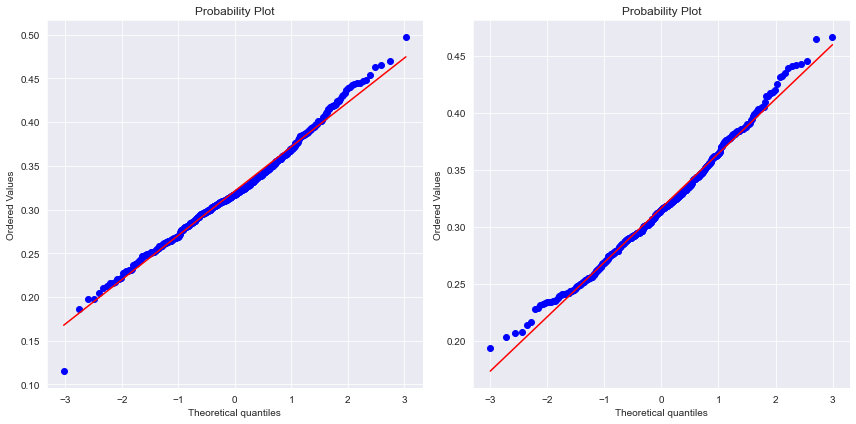

In [18]:
plt.figure(figsize = (12, 6))

ax = plt.subplot(1, 2, 1)
sps.probplot(X_1, plot=ax)

ax = plt.subplot(1, 2, 2)
sps.probplot(Y_1, plot=ax)

plt.tight_layout();

Какой критерий можно применять в случае нормальных выборок и одинаковой дисперсии? Можно ли его применять для проверке гипотез о признаках DYRK1A_N, BDNF_N? Примените этот критерий для признака BDNF_N, сделайте выводы.

In [19]:
sps.ttest_ind(X_1, Y_1)

Ttest_indResult(statistic=1.440470979622491, pvalue=0.15002536864087548)

**Вывод:** В таком случае можно применять критерий Стьюдента. Мы не можем применять данный критерий ни к BDNF_N, ни к DYRK1A_N, так как она имеет гамма распределение(из прошлых ноутбуков).

#### 3. Зависимость уровня экспрессии от генотипа для всех исследуемых белков

Задача заключается в том, чтобы среди всех белков отобрать для дальнейшего более подробного анализа те, по которым уровень экспрессии гена отличается по двум генотипам. Для решения задачи проверьте гипотезы об однородности по генотипам для каждого белка с использованием критерия Уилкоксона-Манна-Уитни.

Почему в данном случае стоит использовать его, а не критерий Стьюдента?

Не забудьте о множественной проверке гипотез. Заметим, что цель исследований &mdash; **отбор** признаков для дальнейшего анализа. Какой метод стоит применять в данном случае? *Обратите внимание на то, как устроены данные.*

Распечатайте результаты МПГ для всех признаков. Сделайте вывод.

**Ответы на вопросы**: Критерий Уилкоксона является не требует наличия нормального распределения сравниваемых выборок. В данном случае лучше использовать критерий Холма, так как могут присутствовать зависимости между выборками.

In [20]:
data_exp = pd.DataFrame()
data_exp["protein"] = columns=data.columns[1:78]
pvals = np.array([])

for protein in data.columns[1:78]:
    control_prot = data[data["Genotype"] == "Control"][protein].dropna()
    down_prot = data[data["Genotype"] == "Ts65Dn"][protein].dropna()
    stat, pval = sps.mannwhitneyu(control_prot, down_prot, alternative='two-sided')
    pvals = np.append(pvals, pval)

data_exp["pval before correction"] = pvals
result = multipletests(pvals, alpha = 0.05, method="h")
data_exp["pval after correction"] = result[1]
data_exp["H0 rejection"] = result[0]

display(data_exp.head(77))

data_exp = data_exp[data_exp["H0 rejection"]]

display(data_exp)

,protein,pval before correction,pval after correction,H0 rejection
0,DYRK1A_N,4.694865e-17,3.333354e-15,True
1,ITSN1_N,2.603971e-32,1.979018e-30,True
2,BDNF_N,1.321605e-01,1.000000e+00,False
3,NR1_N,2.923673e-03,1.081759e-01,False
4,NR2A_N,2.240291e-06,1.164951e-04,True
...,...,...,...,...
72,SYP_N,3.297748e-14,2.275446e-12,True
73,H3AcK18_N,2.130316e-08,1.278190e-06,True
74,EGR1_N,1.587205e-05,7.777304e-04,True
75,H3MeK4_N,1.180069e-04,5.192302e-03,True


,protein,pval before correction,pval after correction,H0 rejection
0,DYRK1A_N,4.694865e-17,3.333354e-15,True
1,ITSN1_N,2.603971e-32,1.979018e-30,True
4,NR2A_N,2.240291e-06,1.164951e-04,True
8,pCREB_N,2.159199e-09,1.338703e-07,True
14,pNR1_N,5.576015e-08,3.178329e-06,True
15,pNR2A_N,1.206455e-11,7.962600e-10,True
16,pNR2B_N,1.126537e-04,5.069419e-03,True
18,pRSK_N,7.584438e-05,3.488842e-03,True
19,AKT_N,7.203339e-04,2.953369e-02,True
20,BRAF_N,4.527456e-09,2.761748e-07,True


Для каждого признака посчитайте оценку сдвига. Сделайте вывод.

In [21]:
Ws = np.array([])
for protein in data_exp["protein"]:
    control_prot = data[data["Genotype"] == "Control"][protein].dropna()
    down_prot = data[data["Genotype"] == "Ts65Dn"][protein].dropna()
    X_prot = control_prot.to_numpy()
    Y_prot = down_prot.to_numpy()
    n_prot = len(X)
    m_prot = len(Y)
    W_prot = X_prot.reshape(-1, 1) - Y_prot
    Ws = np.append(Ws, np.median(W_prot))
data_exp["shift estimtion"] = Ws
display(data_exp)

,protein,pval before correction,pval after correction,H0 rejection,shift estimtion
0,DYRK1A_N,4.694865e-17,3.333354e-15,True,-0.067874
1,ITSN1_N,2.603971e-32,1.979018e-30,True,-0.114045
4,NR2A_N,2.240291e-06,1.164951e-04,True,0.269391
8,pCREB_N,2.159199e-09,1.338703e-07,True,-0.012035
14,pNR1_N,5.576015e-08,3.178329e-06,True,0.038898
15,pNR2A_N,1.206455e-11,7.962600e-10,True,0.079840
16,pNR2B_N,1.126537e-04,5.069419e-03,True,0.065180
18,pRSK_N,7.584438e-05,3.488842e-03,True,-0.015332
19,AKT_N,7.203339e-04,2.953369e-02,True,0.025981
20,BRAF_N,4.527456e-09,2.761748e-07,True,-0.037827


**Вывод:** Мы нашли сдвиги признаков, для которых уровень экспрессии гена отличается по двум генотипам для дальнейшего анализа.

### Задача 2
Для анализа будем использоваться датасет <a href="https://ru.wikipedia.org/wiki/Экспрессия_генов">экспресии генов</a> в нормальных тканях и в <a href="https://ru.wikipedia.org/wiki/Карцинома">карциномах</a>, полученные c помощью нуклеотидных [микрочипов](https://ru.wikipedia.org/wiki/%D0%94%D0%9D%D0%9A-%D0%BC%D0%B8%D0%BA%D1%80%D0%BE%D1%87%D0%B8%D0%BF). Данные опубликованы в работе `Notterman, et al, Cancer Research vol. 61: 2001`.
Всего доступна информация о 18 опухолевых образцах и о соответсвующих им здоровых тканях.

Для лучшего понимания задачи можно почитать следующие статьи:
* https://fb.ru/article/256575/ekspressiya-genov---eto-chto-takoe-opredelenie-ponyatiya
* https://ru.qwe.wiki/wiki/Gene_expression

Загрузим данные

In [22]:
! wget http://genomics-pubs.princeton.edu/oncology/Data/CarcinomaNormalDatasetCancerResearchText.zip
! unzip CarcinomaNormalDatasetCancerResearchText.zip

--2022-05-04 22:29:41--  http://genomics-pubs.princeton.edu/oncology/Data/CarcinomaNormalDatasetCancerResearchText.zip
Resolving genomics-pubs.princeton.edu (genomics-pubs.princeton.edu)... 128.112.102.64
Connecting to genomics-pubs.princeton.edu (genomics-pubs.princeton.edu)|128.112.102.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549752 (537K) [application/zip]
Saving to: ‘CarcinomaNormalDatasetCancerResearchText.zip.2’

CarcinomaNormalData 100%[===================>] 536,87K   633KB/s    in 0,8s    

2022-05-04 22:29:43 (633 KB/s) - ‘CarcinomaNormalDatasetCancerResearchText.zip.2’ saved [549752/549752]

Archive:  CarcinomaNormalDatasetCancerResearchText.zip
replace CarcinomaNormalDatasetCancerResearch.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Загрузим данные в `pandas` и посмотрим на них:

In [23]:
data = pd.read_table(
    "CarcinomaNormalDatasetCancerResearch.txt", 
    skiprows=range(1,8), index_col=0, usecols=range(39)
)
data = data.drop(['Sample'], axis=1)

data.head()

,Description,Tumor 27,Tumor 29,Tumor 34,Tumor 28,Tumor 35,Tumor 8,Tumor 3,Tumor 9,Tumor 4,...,Normal 4,Normal 32,Normal 39,Normal 10,Normal 33,Normal 5,Normal 11,Normal 6,Normal 12,Normal 40
Accession Number,,,,,,,,,,,,,,,,,,,,,
X53416,Human mRNA for actin-binding protein (filamin)...,70.0,108.0,75.0,871.0,-92.0,21.0,225.0,-346.0,-378.0,...,632.0,1412.0,1122.0,644.0,1760.0,488.0,164.0,1282.0,68.0,928.0
M83670,"""Human carbonic anhydrase IV mRNA, complete cds""",-81.0,-30.0,-1.0,4.0,-34.0,-13.0,118.0,-35.0,31.0,...,185.0,288.0,416.0,625.0,320.0,564.0,330.0,116.0,718.0,332.0
X90908,H.sapiens mRNA for I-15P (I-BABP) protein,25.0,-7.0,5.0,14.0,14.0,5.0,-5.0,37.0,-29.0,...,4723.0,-21.0,-7.0,-28.0,-8.0,-29.0,-13.0,-4.0,-50.0,4.0
M97496,"""Homo sapiens guanylin mRNA, complete cds""",10.0,60.0,48.0,78.0,19.0,11.0,175.0,42.0,105.0,...,1107.0,731.0,1559.0,1762.0,917.0,1303.0,721.0,542.0,1816.0,412.0
X90908,H.sapiens mRNA for I-15P (I-BABP) protein,22.0,0.0,6.0,-6.0,11.0,-18.0,-40.0,39.0,-54.0,...,3344.0,8.0,5.0,-7.0,-2.0,-9.0,12.0,0.0,-28.0,0.0


Посмотрим также на хвост данных

In [24]:
data.tail()

,Description,Tumor 27,Tumor 29,Tumor 34,Tumor 28,Tumor 35,Tumor 8,Tumor 3,Tumor 9,Tumor 4,...,Normal 4,Normal 32,Normal 39,Normal 10,Normal 33,Normal 5,Normal 11,Normal 6,Normal 12,Normal 40
Accession Number,,,,,,,,,,,,,,,,,,,,,
X54489,Human gene for melanoma growth stimulatory act...,123.0,271.0,127.0,59.0,265.0,3.0,110.0,30.0,97.0,...,3.0,8.0,16.0,8.0,19.0,11.0,3.0,7.0,21.0,32.0
T55008,yb45h04.s1 Homo sapiens cDNA clone 74167 3' si...,2.0,-1.0,7.0,3.0,-2.0,9.0,7.0,-5.0,0.0,...,-4.0,-5.0,-17.0,15.0,-10.0,7.0,-5.0,3.0,22.0,-5.0
M10065,"""Human apolipoprotein E (epsilon-4 allele) gen...",19.0,-51.0,192.0,367.0,126.0,145.0,-14.0,-53.0,-51.0,...,-103.0,39.0,-10.0,-97.0,-1.0,-145.0,-63.0,-69.0,-214.0,72.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В конце прочитались две пустых строки. Удалим их и убедимся, что пропусков в данных нет

In [25]:
data = data.iloc[:-2]
data.isna().sum()

Description    1
Tumor 27       0
Tumor 29       0
Tumor 34       0
Tumor 28       0
Tumor 35       0
Tumor 8        0
Tumor 3        0
Tumor 9        0
Tumor 4        0
Tumor 32       0
Tumor 39       0
Tumor 10       0
Tumor 33       0
Tumor 5        0
Tumor 11       0
Tumor 6        0
Tumor 12       0
Tumor 40       0
Normal 27      0
Normal 29      0
Normal 34      0
Normal 28      0
Normal 35      0
Normal 8       0
Normal 3       0
Normal 9       0
Normal 4       0
Normal 32      0
Normal 39      0
Normal 10      0
Normal 33      0
Normal 5       0
Normal 11      0
Normal 6       0
Normal 12      0
Normal 40      0
dtype: int64

Каждый ряд соответствует какому-то из интересующих нас генов, а колонка соответствует данным об экспресии каждого гена в опухолевых (`Tumor`) и контрольных (`Normal`) клеток.

Явно укажем вещественный тип данных

In [26]:
data.iloc[:, 2:] = data.iloc[:, 2:].astype('float')

Проверим, уникальны ли все образцы в датасете, для этого сравним количество уникальных ID генов с количеством строк:

In [27]:
len(np.unique(data.index)), len(data.index)

(6604, 7464)

Некоторые эксперименты повторялись более одного раза. Оставим те, где средний уровень экспрессии выше.

In [28]:
data['mean_expr'] = data.iloc[:, 1:-1].mean(axis=1)
data.sort_values(by=['mean_expr'], ascending=False)
data = data.groupby('Accession Number').first()

Сохраним описания генов и данные по их экспрессии отдельно. Значение средней экспрессии нам не нужны, поэтому избавимся от них

In [29]:
expr_data, descr = data.drop(
    ['Description', 'mean_expr'], axis=1
), data.Description

In [30]:
expr_data.head()

,Tumor 27,Tumor 29,Tumor 34,Tumor 28,Tumor 35,Tumor 8,Tumor 3,Tumor 9,Tumor 4,Tumor 32,...,Normal 4,Normal 32,Normal 39,Normal 10,Normal 33,Normal 5,Normal 11,Normal 6,Normal 12,Normal 40
Accession Number,,,,,,,,,,,,,,,,,,,,,
BioB,-2.0,-11.0,-17.0,-1.0,-14.0,-8.0,-13.0,31.0,-24.0,-17.0,...,-23.0,-10.0,-13.0,-25.0,-12.0,-10.0,3.0,-3.0,-24.0,-14.0
BioC,12.0,9.0,17.0,18.0,10.0,53.0,-2.0,57.0,-15.0,54.0,...,-16.0,13.0,14.0,-10.0,14.0,-18.0,75.0,-20.0,22.0,3.0
BioD,107.0,65.0,108.0,95.0,94.0,473.0,93.0,161.0,60.0,232.0,...,58.0,104.0,117.0,142.0,123.0,207.0,461.0,137.0,289.0,82.0
D00003,2.0,7.0,1.0,-3.0,0.0,10.0,15.0,-2.0,36.0,-1.0,...,626.0,0.0,0.0,74.0,4.0,13.0,24.0,4.0,4.0,-1.0
D00015,26.0,13.0,13.0,9.0,2.0,10.0,20.0,17.0,21.0,17.0,...,24.0,79.0,22.0,52.0,59.0,40.0,42.0,71.0,43.0,60.0


Для удобства работы транспонируем матрицу данных об экспрессии, и разметим для каждой строки, является ли образец опухолевым или нормой

In [31]:
expr_data = expr_data.T

Осуществим разметку данных

In [32]:
expr_data['Label'] = expr_data.index.map(
    lambda x: "Tumor" if x.split(' ')[0] == 'Tumor' else "Normal"
)

expr_data.head()

Accession Number,BioB,BioC,BioD,D00003,D00015,D00102,D00137,D00173,D00265,D00306,...,Z50753,Z50788,b-actin-3,b-actin-5,b-actin-M,cre,gapdh-3,gapdh-5,gapdh-M,Label
Tumor 27,-2.0,12.0,107.0,2.0,26.0,5.0,18.0,1.0,153.0,-7.0,...,35.0,-1.0,797.0,559.0,849.0,246.0,1214.0,676.0,873.0,Tumor
Tumor 29,-11.0,9.0,65.0,7.0,13.0,2.0,13.0,5.0,145.0,-7.0,...,26.0,3.0,1298.0,409.0,1093.0,414.0,1394.0,477.0,609.0,Tumor
Tumor 34,-17.0,17.0,108.0,1.0,13.0,0.0,11.0,10.0,132.0,-6.0,...,25.0,1.0,862.0,667.0,961.0,449.0,1252.0,635.0,754.0,Tumor
Tumor 28,-1.0,18.0,95.0,-3.0,9.0,10.0,28.0,8.0,73.0,-17.0,...,41.0,-2.0,1047.0,643.0,1100.0,369.0,1313.0,785.0,1013.0,Tumor
Tumor 35,-14.0,10.0,94.0,0.0,2.0,-5.0,6.0,10.0,184.0,10.0,...,29.0,2.0,1253.0,437.0,844.0,345.0,1292.0,497.0,669.0,Tumor


Посмотрим на значения экспрессии случайного гена и сравним плотности этих распределений.

Выберите ген `D00137`  и постройте на одном графике ядерные оценки плотности экспрессии в нормальных и раковых тканях (две оценки).

In [33]:
sns.set_style("whitegrid")

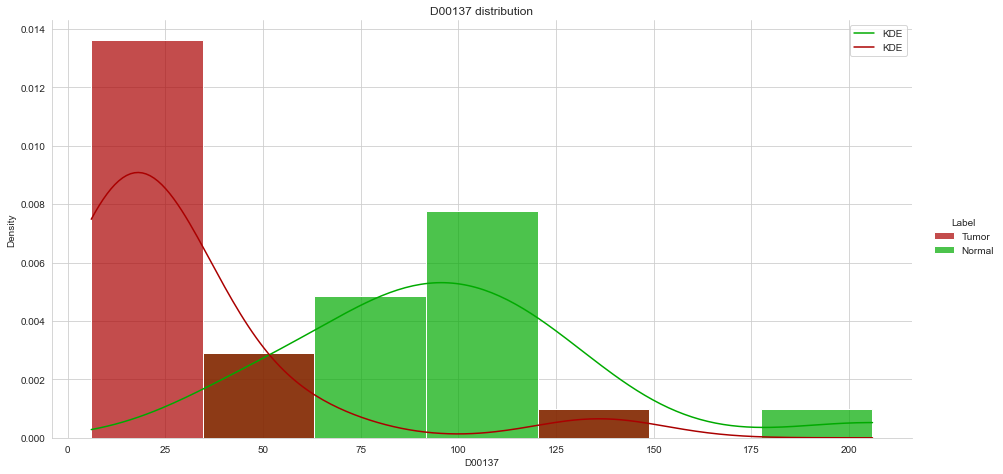

In [34]:
palette = ["#AA0000", "#00AA00"]
sns.displot(data=expr_data, x="D00137", multiple="layer", hue="Label", alpha=0.7, height=6.5, aspect=2, stat="density", kde=True, line_kws={"label":"KDE"}, palette=sns.color_palette(palette, len(palette)))
plt.title('D00137 distribution')
plt.legend();

В анализе данных также часто применяется простой визуальный метод сравнения распределений: boxplot или ящик с усами.  На  графике ящика с усами в наглядном виде указана медиана выборки, выборочные квантили уровня 25% и 75%, а также потенциальные выбросы:


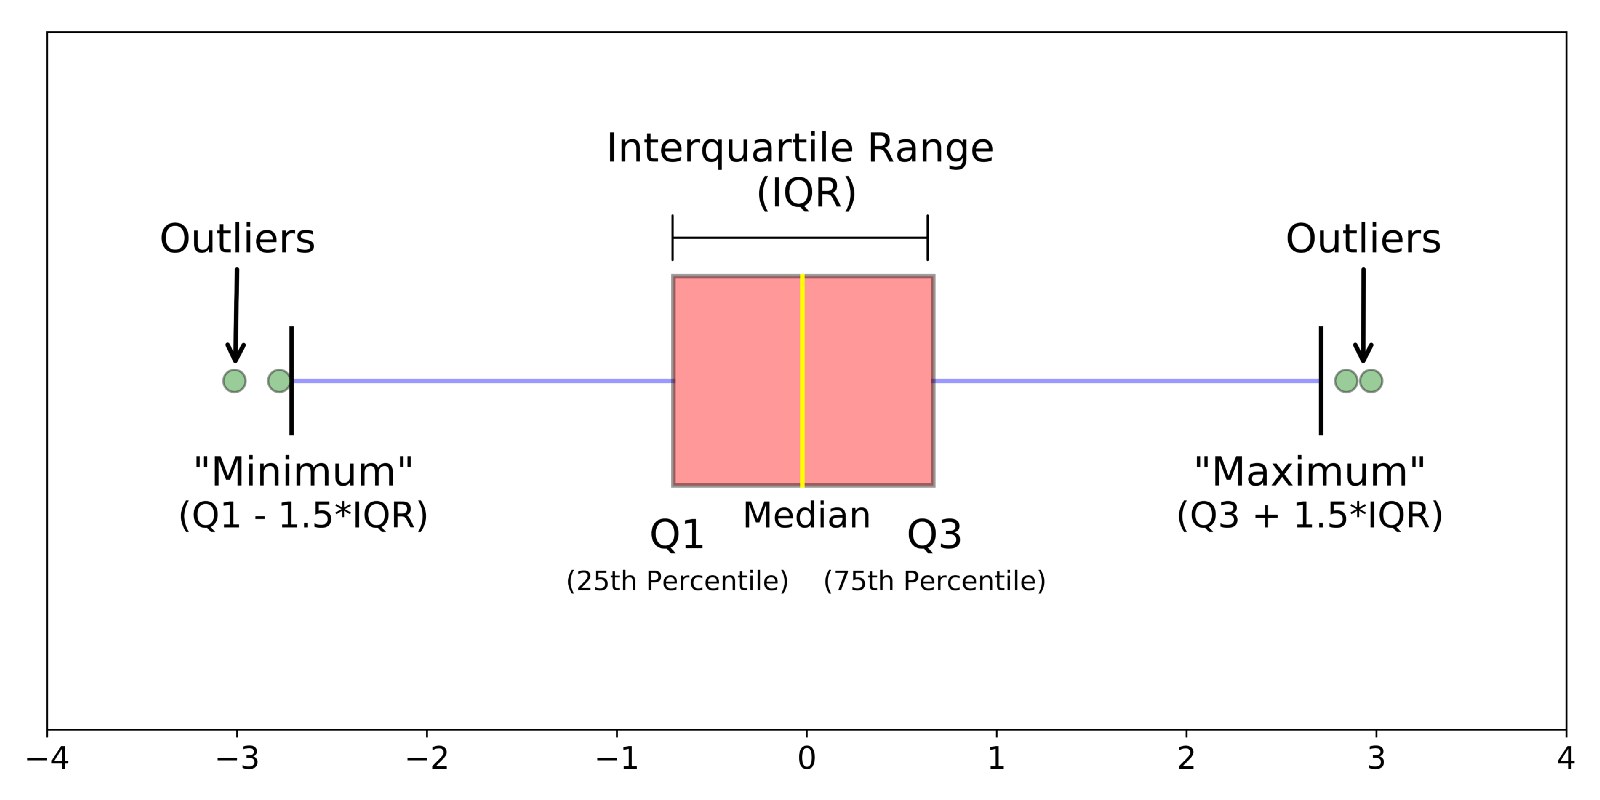

Постройте ящик с усами для гена `D00137`   , так чтобы по оси x был параметр `Label`, а по оси y &mdash; значения экспрессии, т.е. свой ящик для нормальной и раковой тканей. Используйте функцию `sns.boxplot`.

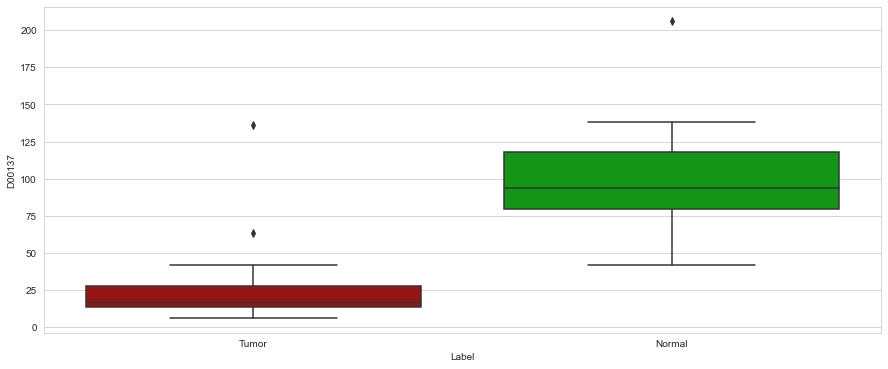

In [35]:
df_D00137 = pd.concat([expr_data[expr_data.Label=='Tumor'].loc[:, ['D00137', 'Label']], 
                     expr_data[expr_data.Label=='Normal'].loc[:, ['D00137', 'Label']]])
plt.figure(figsize=(15,6))
sns.boxplot(data= df_D00137, x="Label", y="D00137", palette=sns.color_palette(palette, len(palette)));

Постройте аналогичные графики, используя `seaborn.violinplot` , популярную модификацию boxplot-а.

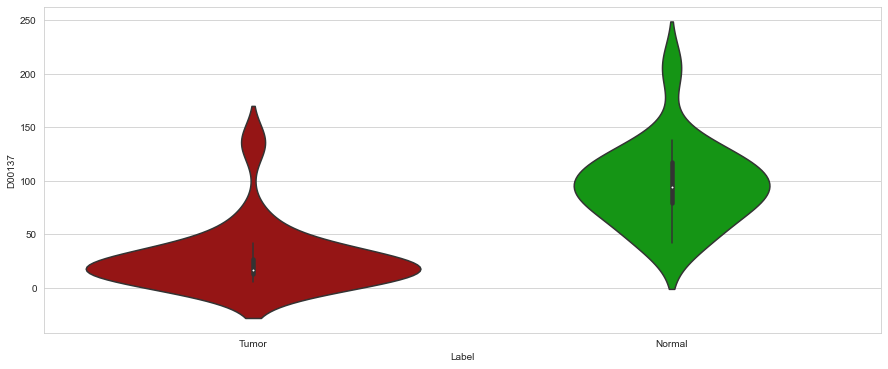

In [36]:
plt.figure(figsize=(15,6))
sns.violinplot(data=df_D00137, x="Label", y="D00137", palette=sns.color_palette(palette, len(palette)));

Как устроен violinplot ? Какой способ визуализации кажется вам более информативным? Почему?

На графиках видно, что для одного случайного гена профили экспрессии возможно различаются.  
Но насколько это статистически достоверно и такова ли эта картина в целом?   
  
  
Для продолжения анализа необходимо понять, как именно были получены данные. Для этого обратимся к статье:  
_Gene intensity information was converted to a mean intensity for each gene by proprietary software (Affymetrix), which includes routines for filtering and centering the data (in these experiments, to 50 intensity units). Expression of genes related to smooth muscle and connective tissue was consistently greater in the normal than the tumor samples, probably because of the greater heterogeneity of tissue type in the normal samples_

Видим, что нормализация данных уже выполнена.
Во многих случаях для визуализации удобно переходить к логарифмическому формату данных.

Предварительный зрительный анализ может сказать очень многое о том, как устроены наши данные. Тем не менее, для получения полной картины простого взгляда на данные недостаточно. Первое на что нужно обрать внимание &mdash; это параметры распределения. Все распределения в первую очередь характеризуются медианой и средним. Для гена `D00137` вычислите медиану и средний уровень экспрессии в опухолевых и нормальных тканей.

In [37]:
print("Tumor average :", np.array(expr_data[expr_data.Label=='Tumor']['D00137']).mean())
print("Tumor median  :", np.median(np.array(expr_data[expr_data.Label=='Tumor']['D00137'])))

print("Normal average:", np.array(expr_data[expr_data.Label=='Normal']['D00137']).mean())
print("Normal median :", np.median(np.array(expr_data[expr_data.Label=='Normal']['D00137'])))

Tumor average : 28.166666666666668
Tumor median  : 17.0
Normal average: 97.0
Normal median : 94.0


Для того, чтобы утверждать, что "ген `X` овер-экспрессирован в опухолевых образцах", недостаточно просто посмотреть на боксплоты, необходимо провести статистический анализ.

Для анализ одного гена проверяются гипотезы о сравнении профилей экспрессий между опухолевыми и контрольными образцами:  
   $\mathsf{H}_0\colon$ для гена `X` не наблюдается разницы средних экспрессий;  
   $\mathsf{H}_1\colon$ для гена `X` наблюдается разница средних экспрессий.
    
Какой критерий стоит выбрать для проверки в предположении нормальности распределений? Воспользуйтесь этим критерием для проверки гипотезы для гена `Human class I alcohol dehydrogenase beta-1 subunit, allele 1 mRNA, complete cds` (см. столбец `Description`).

In [38]:
for i in range(len(data["Description"])):
    if data["Description"][i] and "Human class I alcohol dehydrogenase beta-1 subunit, allele 1 mRNA, complete cds" in data["Description"][i]:
        print(expr_data.columns[i])

sps.ttest_ind(expr_data[expr_data.Label=='Tumor']['D00137'], expr_data[expr_data.Label=='Normal']["D00137"])


D00137


Ttest_indResult(statistic=-5.985803078987308, pvalue=8.985413562048107e-07)

Проинтерпретируйте результаты:

Отвергаем нулевую гипотезу.

Давайте проверим, что наши данные действительно разделяются на два разных распределения. Для этого проверим, как будет работать этот же метод, если случайным образом перемешать метки подгрупп. Реализуйте случайное сэмплирование с помощью функции `random.choice` из библиотеки `numpy` и посмотрите, как изменится p-value (и изменится ли).

In [39]:
shuffled = np.random.choice(expr_data["D00137"].to_numpy(), 36)
p = sps.ttest_ind(shuffled[1::2], shuffled[::2])[1]
print("pval     :", p)
print("rejection:", p < 0.05)

pval     : 0.12657869525186044
rejection: False


Сделайте вывод

При случайном сэмплировании мы надеимся получить две примерно одинаковые выборки. Гипотеза не отвергается.

И, наконец, самое интересное. Посчитайте, в каком проценте генов, для которых с уровнем значимости 0.05 наблюдается овер-экспрессия в опухолевых тканях. При этом важно выполнить поправку на множественное тестирование.

Сначала выполним несколько учебных заданий. 

а*) Реализуйте критерий, который вы использовали в предыдущем пункте, самостоятельно. 

In [40]:
<...>

SyntaxError: invalid syntax (3000440494.py, line 1)

б) Реализуйте поправку Бонферрони (метод Бонферрони) самостоятельно. Функция должна возвращать результаты отвержения гипотез и скорректированные p-value.

In [41]:
def bonferroni(pvals, alpha):
    new_pvals = np.minimum(np.array(pvals) * len(pvals), 1)
    return new_pvals < alpha, new_pvals

в) Проведите МПГ с использованием вашей реализации и с использованием реализации критерия из scipy и МПГ из statsmodels. В случае, если вы не выполняли пункт а), используйте только вашу реализацию пункта б). Сравните результаты.

In [42]:
pvals = np.array([])
for gene in expr_data.columns[::-1]:
    try:
        pval = sps.ttest_ind(expr_data[expr_data.Label=='Tumor'][gene], expr_data[expr_data.Label=='Normal'][gene])[1]
        pvals = np.append(pvals, pval)
    except:
        continue
res1 = bonferroni(pvals, 0.05)
res2 = multipletests(pvals=pvals, alpha=0.05, method="b")
print(sum(res1[0] != res2[0]))

0


Какие методы контроля FWER можно использовать в данной задаче? Сделайте проверку с использованием наилучшего (наиболее мощного) возможного метода. Используйте стандартные реализации.

In [43]:
res3 = multipletests(pvals=pvals, alpha=0.05, method="h")

Далее используйте результаты последней проверки (с использованием наилучшего метода). Постройте гистограмму полученных значений p-value и скорректированных.

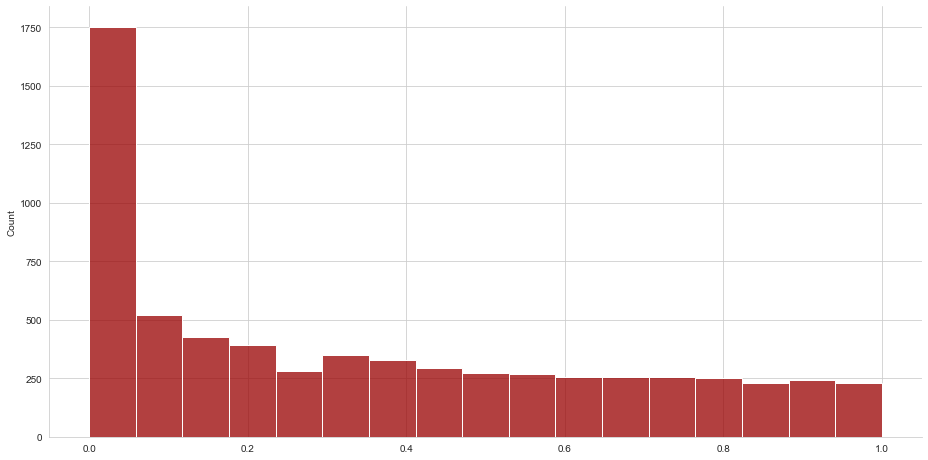

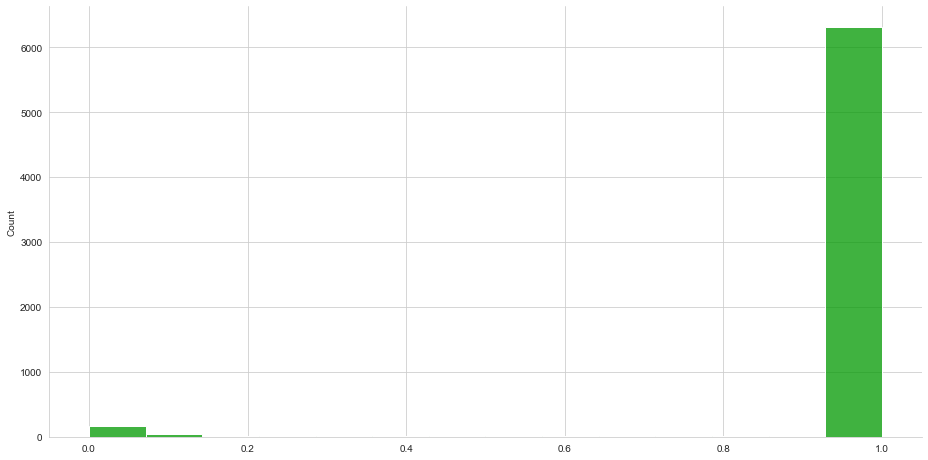

In [44]:
sns.displot(pvals, height=6.5, aspect=2, line_kws={"label":"KDE"}, color="#990000");
sns.displot(res3[1], height=6.5, aspect=2, line_kws={"label":"KDE"}, color="#009900");

Напечатайте число генов, для которых можно отвергнуть нулевую гипотезу, а также их долю среди всех генов.

In [45]:
print("total rejected   :", sum(res3[0]))
print("fraction rejected:", sum(res3[0])/len(res3[0]))


total rejected   : 145
fraction rejected: 0.021956390066626287


Посмотрим, какие же гены оверэкспрессированы. В коде ниже `p_vals_adjusted` &mdash; скорректированные значения p-value.

In [46]:
for name, function in zip(
    expr_data.columns[np.where([res3[1] < 0.05])[1]], 
    descr[np.where([res3[1] < 0.05])[1]]
):
    print(name + ": " + function)

D00265: "Human cytochrome c mRNA, carboxyl-terminal region and 3' non-coding region"
D00749: "Human T cell surface antigen CD7 gene, exon 4"
D13636: "Human mRNA for KIAA0011 gene, complete cds"
D14657: "Human mRNA for KIAA0101 gene, complete cds"
D14663: "Human mRNA for KIAA0107 gene, complete cds"
D15057: "Human mRNA for DAD-1, complete cds"
D30037: "Human mRNA for phosphatidylinositol transfer protein (PI-TPbeta), complete cds"
D30755: "Human mRNA for KIAA0113 gene, partial cds"
H05672: yl75f10.s1 Homo sapiens cDNA clone 43783 3'
H07114: yl82c07.s1 Homo sapiens cDNA clone 44699 3'
H11125: ym14h08.s1 Homo sapiens cDNA clone 48206 3' similar to gb:D13639 G1/S-SPECIFIC CYCLIN D2 (HUMAN);
H11650: ym17g05.s1 Homo sapiens cDNA clone 48176 3' similar to gb:M36341 ADP-RIBOSYLATION FACTOR 4 (HUMAN);
H20802: yn64g07.s1 Homo sapiens cDNA clone 173244 3'
H21944: yl35d07.s1 Homo sapiens cDNA clone 160237 3' similar to SP:CAVE_CANFA P33724 CAVEOLIN ;
H22573: yl30a12.s1 Homo sapiens cDNA clone 1597